# Use STHDio to crop ST data into small patch for quick analysis.
- Download or put HD ST data in ../testdata/VisiumHD/ , with fullres image btf file and the spatial square_002um folder.
- Acknowledgement: public data from 10X Genomics, Colon cancer VisiumHD
## To reanalyze the entire VisiumHD sample, basic inputs shall be downloaded from:
- https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-human-crc
- square_002um (contains filtered_feature_bc_matrix.h5 and spatial/tissue_positions.csv)
- Visium_HD_Human_Colon_Cancer_tissue_image.btf


In [1]:
import importlib as imp
import sys
sys.path.append('../')

import squidpy as sq
import scanpy as sc

import matplotlib.pyplot as plt
import numpy as np

from STHD import sthdio

/hpc/group/yizhanglab/yiz/venv/stvit-cpu/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


### load data fullres image using STHDIO, takes minute

In [2]:
hd_data_square_002um_path = '../testdata/VisiumHD/square_002um/' # shall contain filtered_feature_bc_matrix.h5 
hd_fullres_img_btf_path = '../testdata/VisiumHD/Visium_HD_Human_Colon_Cancer_tissue_image.btf'

In [3]:
full_data = sthdio.STHD(
    spatial_path = hd_data_square_002um_path, 
    counts_data = 'filtered_feature_bc_matrix.h5', 
    full_res_image_path = hd_fullres_img_btf_path, 
    load_type = 'original'
)

/hpc/group/yizhanglab/yiz/venv/stvit-cpu/lib64/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/group/yizhanglab/yiz/venv/stvit-cpu/lib64/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Crop and save data

In [4]:
# crop10: tumor epithelial
x1 = 56250
y1 = 8250
d = 1100

# crop5: Trich
#x1 = 45450
#y1 = 4100
#d = 1100

# crop15: Trich
#x1 = 62800
#y1 = 11000
#d = 1100

x2 = x1+d
y2 = y1+d
crop_data = full_data.crop(
    x1, x2, y1, y2, 
    full_data.adata.uns['spatial']['Visium_HD_Human_Colon_Cancer']['scalefactors']['tissue_hires_scalef']
)

#crop_data.save('../testdata/crop10')

Input Pixel is aligned to 56250, 8240, 57340, 9330


/hpc/group/yizhanglab/yiz/venv/stvit-cpu/lib64/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


## look at the cropped region, full resolution H&E image crop

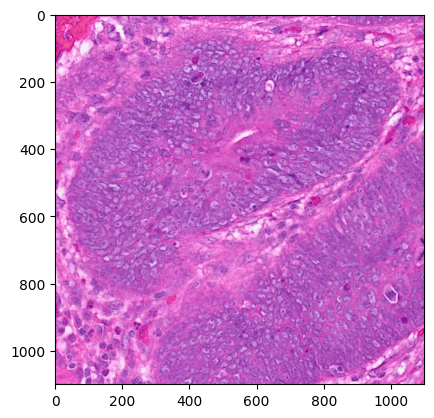

In [6]:
img = full_data.load_img()
img_crop = full_data.crop_img(img, x1, y1, x2, y2)
plt.imshow(img_crop)

# Read the saved crops

In [7]:
sthdata = sthdio.STHD(
    spatial_path = '../testdata/crop10/adata.h5ad.gzip', 
    counts_data = 'filtered_feature_bc_matrix.h5', 
    full_res_image_path = '../testdata/crop10/fullresimg_path.json', 
    load_type = 'crop'
)

# add basic statistics
sthdata.adata.var_names_make_unique()
sthdata.adata.var["mt"] = sthdata.adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(sthdata.adata, qc_vars=["mt"], inplace=True)

/hpc/group/yizhanglab/yiz/venv/stvit-cpu/lib64/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
sthdata.adata

AnnData object with n_obs × n_vars = 22336 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

### squidpy plotting needs crop coords of the crop data to plot highres cut image.

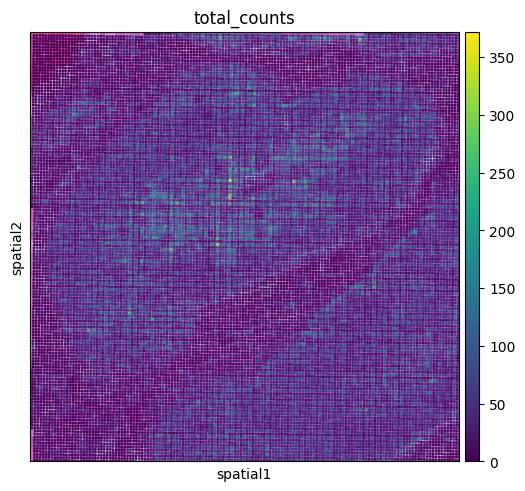

In [9]:
crop_coord = sthdata.get_sequencing_data_region()

# scatter plot on crop
sq.pl.spatial_scatter(
    sthdata.adata,
    color=["total_counts"],
    crop_coord=[crop_coord], # should be coordinates in orignal fullres image
    #scalebar_dx=3.0,
    #scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    #figsize=(20,20),
    #shape='square',
    #cmap='Reds'
)

# notes


When you see following error:

```partially initialized module 'cv2' has no attribute '_registerMatType```

Then firstly run `pip list`, and identify all relevant packages w.r.t. opencv. then pip uninstall all of them. Then reinstall `pip install opencv-python`